In [33]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L2

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [34]:
train_df = pd.read_csv("df//train_df.csv")
val_df = pd.read_csv("df//val_df.csv")
train_df.head()

,path,pH
0,close_seg\6\6k--74-_jpg-region_2.png,6
1,close_seg\6\6K--51-_jpg-region_2.png,6
2,close_seg\6\6K--84-_jpg-region_2.png,6
3,close_seg\6\6K--64-_jpg-region_2.png,6
4,close_seg\6\6K--58-_jpg-region_2.png,6


In [35]:
print(len(listdir("jpgData//6")))
print(len(listdir("jpgData//7")))
print(len(listdir("jpgData//8")))
print(len(listdir("jpgData//9")))

230
379
280
160


In [36]:
train_df["pH"].value_counts()

pH
6    128
7    128
8    128
9    128
Name: count, dtype: int64

In [37]:
x_col = "path"
y_col = "pH"
batch_size = 32
epochs = 256
lr = 1e-5
image_size = (128,128)
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    #  width_shift_range = 0.1,
                                    #  height_shift_range = 0.1, 
                                    #  zoom_range = 0.2,
                                    #  shear_range = 0.5,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     channel_shift_range = 32.0,
                                    #  brightness_range = (0.3,1.0),
                                    #  rotation_range = 15,
                                     )
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)


Found 512 validated image filenames.
Found 131 validated image filenames.


In [39]:
clear_session()
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
inputs = Input((image_size[0], image_size[1], channels))
# s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

flatten_1 = Flatten()(nestnet_output_4)

dense_1 = Dense(units=128, activation='relu')(flatten_1)

# dense_2 = Dense(units=256, activation='relu')(dense_1)

# drop_h_1 = Dropout(0.5) (flatten_1)

final_layer = Dense(units=1, activation="linear")(dense_1)

model = Model([inputs], [final_layer])
model.compile(optimizer=Adam(learning_rate=lr), loss="mean_squared_error", metrics=["mae"])

# plot_model(
#     model,
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=46,
#     layer_range=None
# )

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [41]:
# model.compile(optimizer=Adam(lr), loss='mean_squared_error', metrics=['mae'])

In [42]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', patience=8, mode="min", restore_best_weights=True)

history = model.fit(train_generator, validation_data = val_generator, 
                        epochs = epochs, callbacks=[reduce_lr, es], 
                        verbose = 1)

Epoch 1/256
16/16 [==============================] - 11s 563ms/step - loss: 63.2231 - mae: 7.7838 - val_loss: 51.6404 - val_mae: 7.0962 - lr: 1.0000e-05
Epoch 2/256
16/16 [==============================] - 9s 539ms/step - loss: 48.0003 - mae: 6.7301 - val_loss: 37.2682 - val_mae: 5.9982 - lr: 1.0000e-05
Epoch 3/256
16/16 [==============================] - 9s 540ms/step - loss: 35.9516 - mae: 5.7535 - val_loss: 25.3834 - val_mae: 4.9081 - lr: 1.0000e-05
Epoch 4/256
16/16 [==============================] - 9s 542ms/step - loss: 25.0745 - mae: 4.7499 - val_loss: 15.5555 - val_mae: 3.7757 - lr: 1.0000e-05
Epoch 5/256
16/16 [==============================] - 9s 542ms/step - loss: 16.9417 - mae: 3.7927 - val_loss: 8.1627 - val_mae: 2.6182 - lr: 1.0000e-05
Epoch 6/256
16/16 [==============================] - 9s 542ms/step - loss: 9.9895 - mae: 2.7649 - val_loss: 3.5854 - val_mae: 1.5454 - lr: 1.0000e-05
Epoch 7/256
16/16 [==============================] - 9s 545ms/step - loss: 6.0954 - mae: 2

In [43]:
train_loss = history.history['loss']
train_mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train MAE: {:.4f}".format(train_mae[best_epoch]))
print("Final Test MAE: {:.4f}".format(val_mae[best_epoch]))

Best Epoch:  7
Final Train Loss: 3.6917
Final Validation Loss: 1.3840
Final Train MAE: 1.5789
Final Test MAE: 1.0116


In [44]:
import warnings
warnings.filterwarnings("ignore")

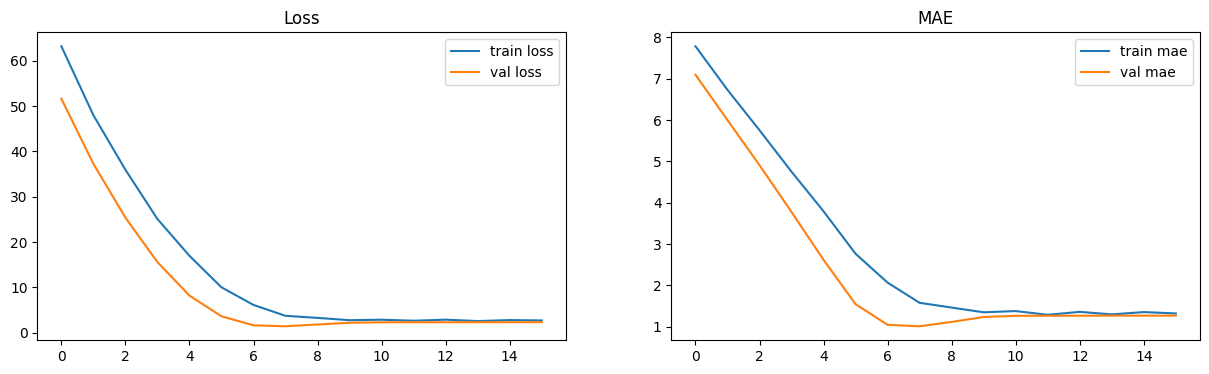

In [45]:

fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.lineplot(train_loss , ax=ax[0], label='train loss')
sns.lineplot(val_loss, ax=ax[0], label='val loss')
# ax[0].legend(labels=['train loss','validation loss'],loc="upper right")
ax[0].set_title('Loss')

sns.lineplot(train_mae, ax=ax[1], label='train mae')
sns.lineplot(val_mae, ax=ax[1], label='val mae')
# ax[1].legend(labels=['train acc','validation acc'],loc="upper right")
ax[1].set_title('MAE')

plt.show()


In [46]:
tester = next(val_generator)

In [47]:
for i in range(len(tester[0])):
    test = tester[0][i]
    truth = tester[1][i]
    result = round(model.predict(test.reshape(1,image_size[0],image_size[1],channels))[0][0],2)
    print('Truth:',truth)
    print('Result:',result)


1/1 [==============================] - 0s 296ms/step
Truth: 6
Result: 7.79
1/1 [==============================] - 0s 19ms/step
Truth: 9
Result: 7.82
1/1 [==============================] - 0s 19ms/step
Truth: 8
Result: 7.5
1/1 [==============================] - 0s 19ms/step
Truth: 7
Result: 7.48
1/1 [==============================] - 0s 20ms/step
Truth: 6
Result: 7.63
1/1 [==============================] - 0s 19ms/step
Truth: 8
Result: 7.96
1/1 [==============================] - 0s 19ms/step
Truth: 8
Result: 7.76
1/1 [==============================] - 0s 19ms/step
Truth: 9
Result: 7.26
1/1 [==============================] - 0s 19ms/step
Truth: 7
Result: 7.85
1/1 [==============================] - 0s 19ms/step
Truth: 7
Result: 7.83
1/1 [==============================] - 0s 20ms/step
Truth: 9
Result: 7.53
1/1 [==============================] - 0s 19ms/step
Truth: 9
Result: 7.35
1/1 [==============================] - 0s 19ms/step
Truth: 9
Result: 7.44
1/1 [==============================] -